# <center>CITS5508 Lab sheet 4 Project 1</center>

**Name:** Alastair Mory<br>
**Student number:** 21120848<br>


<br><b>Contents</b><br>
[1 Data Reading, Visualisation and Statistics](#1)<br>

[2 Train test split and data normalisation](#2)<br>

[3 AdaBoost and gradient boosting regressors ](#3)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Boost stages / iterations mean squared error](#3.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[Raw error histograms](#3.2)<br>

[4 Conclusion and discussion](#4)<br>


In [1]:
from typing import Any

from IPython.display import display, HTML

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# 1 Data Reading, Visualisation and Statistics <a name="1">

In [2]:
# Read data in
data = pd.read_csv('winequality-white.csv', sep=';')

# Display example rows
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


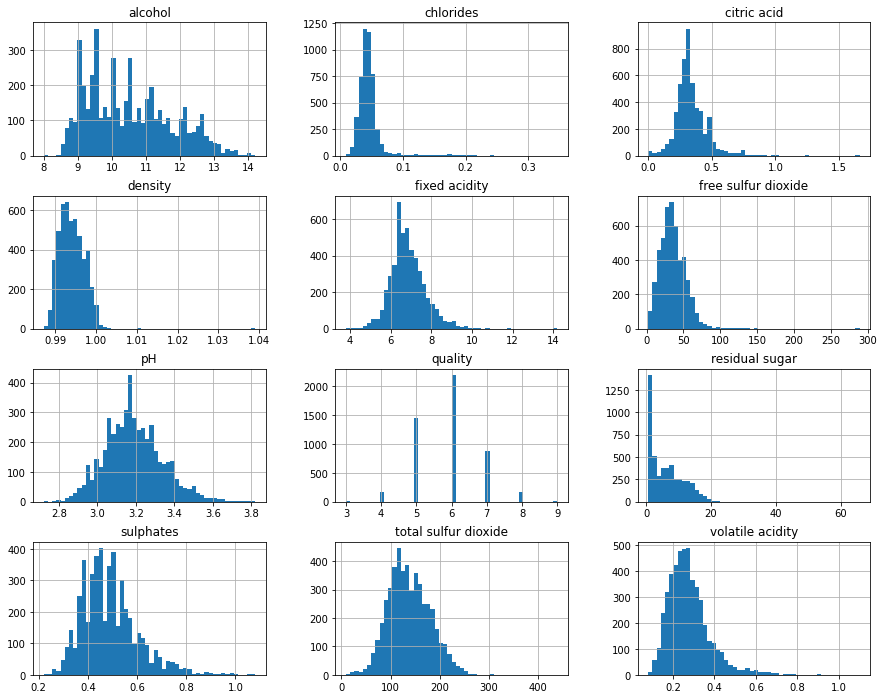

In [3]:
# Histogram of numerical features
_ = data.hist(bins=50, figsize=(15,12))

In [4]:
# Statistics for numerical features
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


From the above histograms and statistics we can see that most parameter distributions are relatively unskewed (with the exception of 'residual sugar', and to a lesser degree 'alcohol'), despite generally having long tails. It is also worth noting the parameter we wish to predict (quality) consists of only seven integer values.

# 2 Train test split and data normalisation <a name="2">

Here we do a 85/15 train/test split of the data and then perform feature scaling (this is necessary because the support vector regressor is sensitive to feature scales).

In [5]:
# Perform 85/15 train test split
y = data['quality']
x = data.drop(columns=['quality'])

train_x, test_x, train_y, test_y= train_test_split(x, y,
                                                   test_size=0.15,
                                                   train_size=0.85)
train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)
train_y = train_y.reset_index(drop=True)
test_y = test_y.reset_index(drop=True)


# Normalise data
scaler = StandardScaler().fit(train_x)
train_x = scaler.transform(train_x)
test_x = scaler.transform(test_x)


# 3 AdaBoost and gradient boosting regressors <a name="3">

In [6]:
# Several helper functions to clean up code in later cells.

def get_results(regressor,  # untrained regressor,
                  train_x: pd.DataFrame, train_y: pd.Series,
                  test_x: pd.DataFrame, test_y: pd.Series):
    """
    Fit and run staged predictions for given regressor
    """
    results = {
        'y_train_true': train_y,
        'y_train_pred': [],
        'y_test_true': test_y,
        'y_test_pred': []
    }
    
    # Train regressor
    regressor.fit(train_x, train_y)
    
    # Run regressor prediction
    for y_stage in regressor.staged_predict(train_x):
        y_pred = np.round(y_stage)
        results['y_train_pred'].append(y_pred)
        
    for y_stage in regressor.staged_predict(test_x):
        y_pred = np.round(y_stage)
        results['y_test_pred'].append(y_pred)
        
    return results


def get_mse(results):
    """
    Calculate mean squared errors for all stages of a given regressor.
    """
    train_mse = []
    for y_pred in results['y_train_pred']:
        train_mse.append(mean_squared_error(results['y_train_true'], y_pred))
    test_mse = []
    for y_pred in results['y_test_pred']:
        test_mse.append(mean_squared_error(results['y_test_true'], y_pred))   
    return (train_mse, test_mse)


def print_mse(results, regressor_name="Regressor"):
    """Print MSE table from results"""
    train_mse, test_mse = get_mse(results)
    row_names = ["Iteration", "Train MSE", "Test MSE"]
    column_names = ["1", "2", "3", "4", "5", "6"]
    mse_table = pd.DataFrame(data=([column_names, train_mse, test_mse]),
                             index=row_names)
    html_table = mse_table.to_html(header=False,
                                   float_format=lambda a: str(round(a,4)),
                                   justify="left")
    print(f"{regressor_name} Intermediate Model MSE")
    display(HTML(html_table))


def plot_mse(results,  # dict returned by get_results()
             regressor_name='Regressor'):
    """Plot MSEs from results."""
    n_stages = len(results['y_train_pred'])
    
    train_mse, test_mse = get_mse(results)
    
    plt.figure()
    plt.title(regressor_name)

    plt.scatter(np.arange(n_stages),train_mse)
    plt.scatter(np.arange(n_stages),test_mse)
    plt.plot(train_mse, label="Train MSE")
    plt.plot(test_mse, label="Test MSE")
    
    plt.xlabel("Boost iteration")
    plt.ylabel("MSE")
    plt.xticks(np.arange(n_stages), np.arange(1, n_stages + 1))
    plt.legend()
    


In [7]:
# Run Adaboost regressor
regr_1 = AdaBoostRegressor(base_estimator=SVR(), n_estimators=6)
regr_1_results = get_results(regr_1, train_x, train_y, test_x, test_y)

In [8]:
# Run gradient boosting regressor
regr_2 = GradientBoostingRegressor(n_estimators=6)
regr_2_results = get_results(regr_2, train_x, train_y, test_x, test_y)

## Boost stages / iterations mean squared error <a name="3.1">

In [9]:
print_mse(regr_1_results, regressor_name="AdaBoost")
print_mse(regr_2_results, regressor_name="Gradient Boosting")

AdaBoost Intermediate Model MSE


Iteration,1,2,3,4,5,6
Train MSE,0.4934,0.4934,0.459,0.4634,0.4494,0.4473
Test MSE,0.581,0.581,0.5401,0.5456,0.5442,0.5388


Gradient Boosting Intermediate Model MSE


Iteration,1,2,3,4,5,6
Train MSE,0.8078,0.8078,0.8078,0.8078,0.8042,0.7812
Test MSE,0.7497,0.7497,0.7497,0.7497,0.7497,0.7469


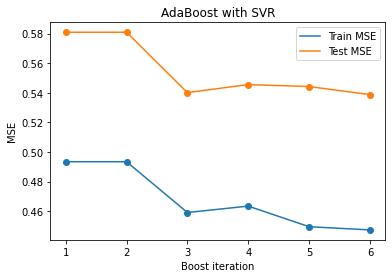

In [10]:
plot_mse(regr_1_results, regressor_name="AdaBoost with SVR")

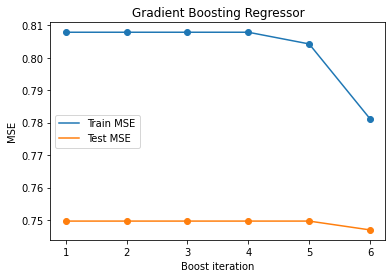

In [11]:
plot_mse(regr_2_results, regressor_name="Gradient Boosting Regressor")

## Raw error histograms <a name="3.2">

In [12]:
def raw_error_hist(results1, results2):
    
    def get_bar_heights(results, x_vals):
        y_train_true = results['y_train_true']
        y_train_pred = results['y_train_pred'][-1]
        y_test_true = results['y_test_true']
        y_test_pred = results['y_test_pred'][-1]
        
        y_train_re = y_train_pred - y_train_true
        y_test_re = y_test_pred - y_test_true
        
        y_train = bar_heights_from_errors(x_vals, y_train_re)
        y_test = bar_heights_from_errors(x_vals, y_test_re)
        
        return (y_train, y_test)
    
    def bar_heights_from_errors(x_vals, x_counts):
        bar_heights = []
        for x in x_vals:
            bar_heights.append((x_counts == x).sum())
        return bar_heights

    
    x = np.arange(-3, 4)  # X axis values
    
    y1_train, y1_test = get_bar_heights(results1, x)
    y2_train, y2_test = get_bar_heights(results2, x)
    
    fig, ax = plt.subplots(ncols=2,figsize=(15, 5))
    ax1 = ax[0]
    ax2 = ax[1]
    
    width = 1 / 3  # Bar widths
    
    rects1 = ax1.bar(x - width/2, y1_train, width, label='AdaBoost')
    rects2 = ax1.bar(x + width/2, y2_train, width, label='Gradient boost')
    
    rects3 = ax2.bar(x - width/2, y1_test, width, label='AdaBoost')
    rects4 = ax2.bar(x + width/2, y2_test, width, label='Gradient boost')
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    fig.suptitle('Histograms of Raw Errors', fontsize=16)
    ax1.set_xlabel('Raw Error')
    ax1.set_ylabel('Occurrences')
    ax1.set_title('Training Raw Errors')
    ax1.legend()
    ax2.set_xlabel('Raw Error')
    ax2.set_ylabel('Occurrences')
    ax2.set_title('Testing Raw Errors')
    ax2.legend()
    


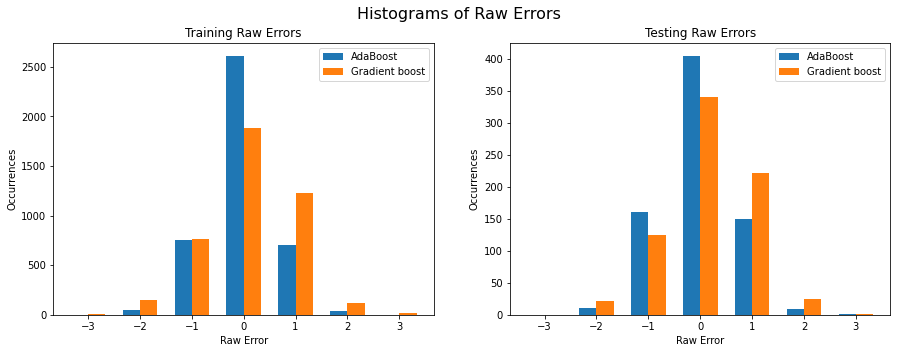

In [13]:
raw_error_hist(regr_1_results, regr_2_results)

# 4 Conclusion and discussion <a name="4">
    
From the line charts of MSE plotted against boost iterations we can see there is a reduction in mse over multiple boosting iterations for both AdaBoost (AB) and Gradient Boosting (GB) regressors. It is also clear that AB performs significantly better than GB, however it is worth noting AB is significantly slower and it is possible to run over 100 iterations of GB in the time it takes AB with SVR to do only 6 iterations, in which case GB will outperform AB.
    
The histograms of raw errors shows again that AB performs better than GB (there is a higher proportion of results with a raw error of zero). We can also observe that AB is relatively balanced in its predictions (there is no bias for over or under estimating wine quality), while GB has a slight positive bias in its wine quality predictions, possibly due to the slight underlying skew of the wine quality values.